# DS LAB Winter Project - A.Y 2022/2023

### Import of the data

We import the development set and we explore some charateristics of the dataset. It contains 9854 records and 10 columns for each records. There are any null values. The class of each recording is defined by the action and the object. 

In [9]:
import pandas as pd 
import numpy as np 
import librosa
import soundfile
import matplotlib.pyplot as plt 
import seaborn as sns
import librosa.display
from IPython.display import Audio

In [11]:
df_dev = pd.read_csv('./dsl_data/development.csv')
df_dev.head()

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40


In [12]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9854 entries, 0 to 9853
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Id                                     9854 non-null   int64 
 1   path                                   9854 non-null   object
 2   speakerId                              9854 non-null   object
 3   action                                 9854 non-null   object
 4   object                                 9854 non-null   object
 5   Self-reported fluency level            9854 non-null   object
 6   First Language spoken                  9854 non-null   object
 7   Current language used for work/school  9854 non-null   object
 8   gender                                 9854 non-null   object
 9   ageRange                               9854 non-null   object
dtypes: int64(1), object(9)
memory usage: 770.0+ KB



We extract the labels and plot the frequency of each label in the dataset. As we can see, there are some classes that are more common than others. So the problem is unbalanced, in the following step, we will proceed with resampling the data. 

<AxesSubplot:>

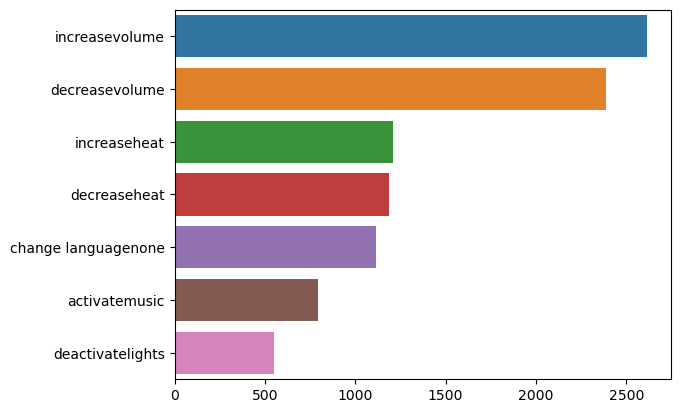

In [14]:
from collections import Counter

labels = []
for i in range(len(df_dev)):
    labels.append(df_dev.loc[i,'action']+df_dev.loc[i,'object'])

labels_count = dict(Counter(labels))
labels_count = dict(sorted(labels_count.items(),key=lambda x: x[1], reverse=True) )
sns.barplot(y= list(labels_count.keys()), x=list(labels_count.values()) )

We can notice that also for the others feautures, there are an imbalance among the values. For examples most of the speakers speak *English (United States)* as first language and for work/school and have *native* fluency level

In [15]:
print("\nSelf-reported fluency level:\n",Counter(df_dev.loc[:,'Self-reported fluency level ']))
print("\nFirst language spoken:\n",Counter(df_dev.loc[:,'First Language spoken']))
print("\nCurrent language used for work/school: \n", Counter(df_dev.loc[:,'Current language used for work/school']))
print("\nGender: \n", Counter(df_dev.loc[:,'gender']))
print("\nAgeRange: \n", Counter(df_dev.loc[:,'ageRange']))


Self-reported fluency level:
 Counter({'native': 9444, 'advanced': 346, 'basic': 56, 'intermediate': 8})

First language spoken:
 Counter({'English (United States)': 9642, 'French (Canada)': 148, 'Spanish (Venezuela)': 35, 'Telugu': 21, 'English (Canada)': 8})

Current language used for work/school: 
 Counter({'English (United States)': 9598, 'English (Canada)': 156, 'English (Australia)': 65, 'Spanish (Venezuela)': 35})

Gender: 
 Counter({'male': 5265, 'female': 4589})

AgeRange: 
 Counter({'22-40': 7496, '41-65': 2115, '65+': 243})


Now we encoded the categorical features and we analyse the data to find correlation among the variables.

In [19]:
df_corr = df_dev.iloc[:,3:]
for i in range(len(df_corr)):
    df_corr.loc[i,'action'] = df_corr.loc[i,'action'] + df_corr.loc[i,'object']
    
df_corr = df_corr.drop(['object'],axis=1)
df_corr = df_corr.rename(columns={'action':'class'})

df_corr['class'].replace(
    ['increasevolume','decreasevolume','increaseheat','decreaseheat','change languagenone','activatemusic','deactivatelights'],
    [0,1,2,3,4,5,6],inplace=True
)

df_corr['Self-reported fluency level '].replace(
        ['native','advanced','basic','intermediate'],
        [0,1,2,3],inplace=True)

df_corr['First Language spoken'].replace(
        ['English (United States)','French (Canada)','Spanish (Venezuela)','Telugu','English (Canada)'],
        [0,1,2,3,4],inplace=True)

df_corr['Current language used for work/school'].replace(
        ['English (United States)','English (Canada)','English (Australia)','Spanish (Venezuela)'],
        [0,1,2,3],inplace=True)

df_corr['gender'].replace(
        ['male','female'], [0,1],inplace=True)

df_corr['ageRange'].replace(
        ['22-40','41-65','65+'], [0,1,2],inplace=True)


<AxesSubplot:>

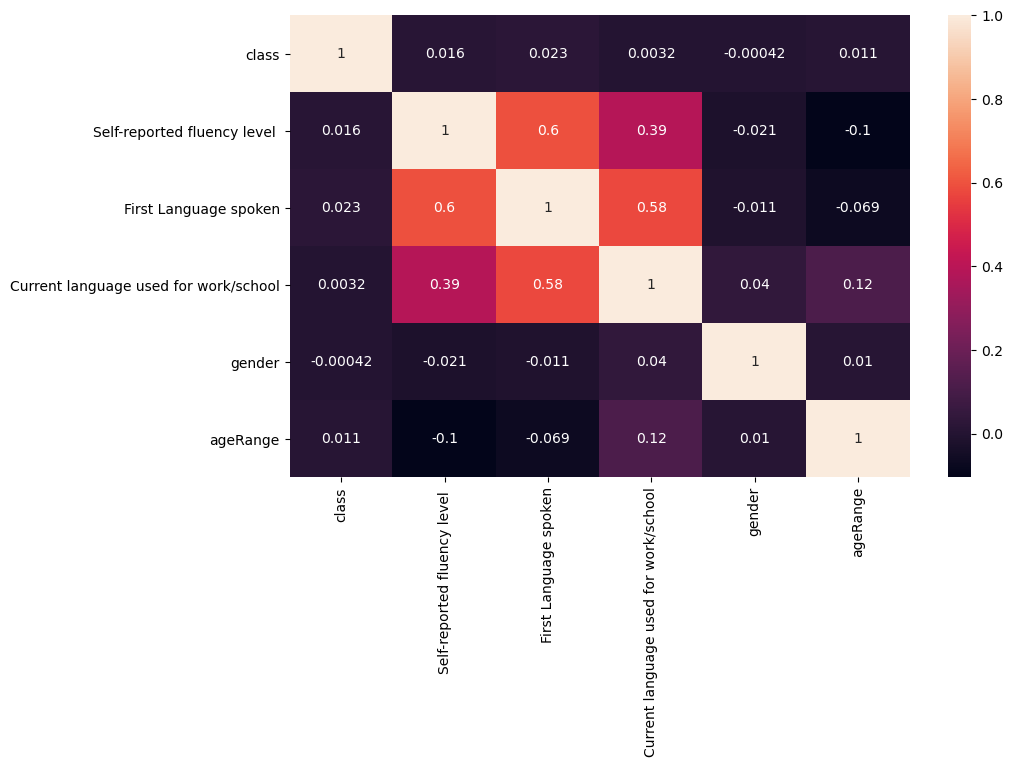

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_corr.corr(), ax=ax, annot=True)

As we expected, there is no correlation between the class (label action + object) and other features. 

### Analysis of audio

We open an audio file and we show its properties in the time domain,frequency domain and with the mel spectrogram

sample rate: 22050
number of sample: (30720,)
Duration:  1.3931972789115645


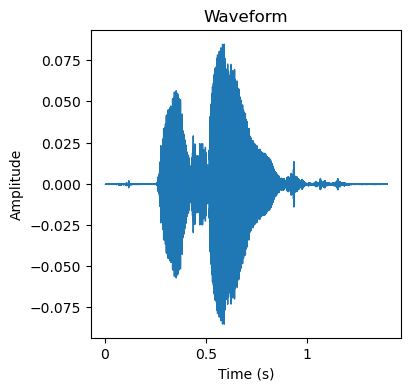

In [34]:
# load a file and plot time-domain signal
file_path = './' + df_dev.loc[1,'path']

signal, sample_rate = librosa.load(file_path)
print("sample rate:",sample_rate)
print("number of sample:",signal.shape)
print("Duration: ",len(signal)/sample_rate)
#waveform
plt.figure(figsize=(4,4))
librosa.display.waveshow(y=signal,sr=sample_rate)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

Audio(signal,rate=sample_rate)

Text(0.5, 1.0, 'Power spectrum')

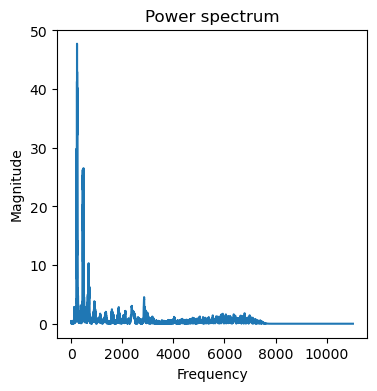

In [35]:
# FFT -> power spectrum
# perform Fourier transform
fft = np.fft.fft(signal)

# calculate abs values on complex numbers to get magnitude
spectrum = np.abs(fft)

# create frequency variable
f = np.linspace(0, sample_rate, len(spectrum))

# take half of the spectrum and frequency
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]

# plot spectrum
plt.figure(figsize=(4,4))
plt.plot(left_f, left_spectrum,)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

To extract the mel spectrogram, we use the *librosa* library

Hop length duration is: 0.011609977324263039s
Window duration is: 0.046439909297052155s
(128, 121)


Text(0.5, 1.0, 'Spectrogram (dB)')

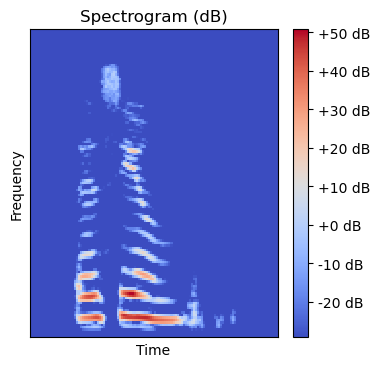

In [36]:
# STFT -> spectrogram
hop_length = 256 # in num. of samples
n_fft = 1024 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("Hop length duration is: {}s".format(hop_length_duration))
print("Window duration is: {}s".format(n_fft_duration))



# apply logarithm to cast amplitude to Decibels
mel_spectrogram = librosa.amplitude_to_db(librosa.feature.melspectrogram(y=signal,n_fft=1024,hop_length=256),ref=np.mean)
print(mel_spectrogram.shape)

plt.figure(figsize=(4,4))
librosa.display.specshow(mel_spectrogram, sr=sample_rate)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

Most of recordings have different durations and contain periods of silence. we try to remove the silence from the audio. In this way we have a significant reduction in the number of samples.  

In [30]:
def remove_silence(sample, sr= sample_rate, top_db = 20):
    y = np.array(sample, dtype = np.float64)
    yt, _ = librosa.effects.trim(y, top_db= top_db)
    return yt

number of sample: 13824
Duration:  0.626938775510204


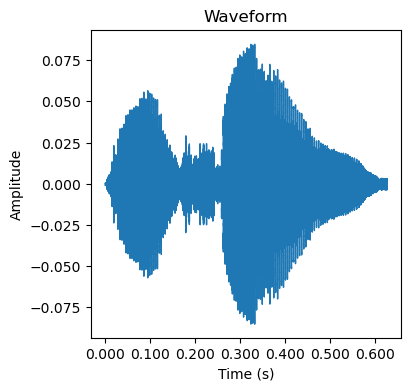

In [37]:
#try to remove silence -> below 20 db
y = remove_silence(signal)

print("number of sample:",len(y))
print("Duration: ",len(y)/sample_rate)
#waveform
plt.figure(figsize=(4,4))
librosa.display.waveshow(y=y,sr=sample_rate)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

Audio(y, rate=sample_rate)

Now we load all the recordings and we study the distribution of durations of recordings after and before removing silence. 

In [38]:
#X_signal stores each signal
X_signal = []
sample_rate = 22050

for i in range(len(df_dev)):
    path = './'+df_dev.loc[i,'path']
    signal, sample_rate = librosa.load(path,sr=sample_rate)
    X_signal.append(signal)

In [40]:
def show_length_distribution(signals, rate = sample_rate):
    durations = [len(x)/rate for x in signals]
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})

    sns.boxplot(x = durations, ax=ax_box, linewidth = 0.9, color=  '#9af772')
    sns.histplot(x = durations, ax=ax_hist, bins = 'fd', kde = True)

    ax_box.set(xlabel='')
    
    title = 'Audio signal lengths'
    x_label = 'duration (seconds)'
    y_label = 'count'

    plt.suptitle(title)
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel(y_label)
    plt.show()
    return durations


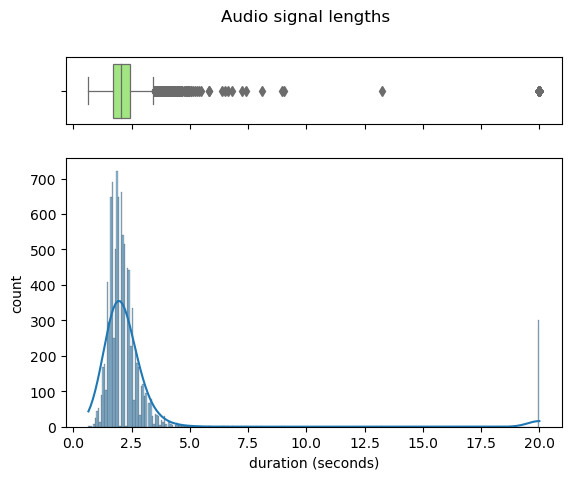

In [41]:
lenghts = show_length_distribution(X_signal)

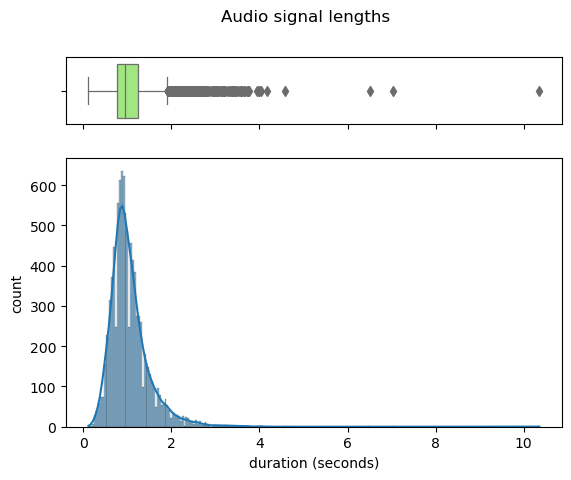

In [42]:
X_signal_removed_silence = [remove_silence(x) for x in X_signal]
_ = show_length_distribution(X_signal_removed_silence)

### Feature extraction

Let's extract the mel spectrogram from each signal. Since we should have the same number of features for each recordings, the mel spectrogram, which is a matrix, is divided into blocks. 

For each block, we compute some statistics like mean and standard deviation. The number of blocks depends on the number of split along rows and columns. We run a grid search to figure out the best number of splits.

In [43]:
def get_spectograms(X,n):
    
    #it contains all spectrogram
    X_spectograms = []
    
    for x in X:
        #mel spectrogram of the signal 
        sp = librosa.amplitude_to_db(librosa.feature.melspectrogram(y=x,n_fft=1024,hop_length=256,n_mels=256),ref=np.mean)
        
        x_spectrum_blocks = []
        #split rows
        for r_split in np.array_split(sp,n,axis=0):
            
            #split columns
            for c_split in np.array_split(r_split,n,axis=1):
                
                if c_split.size == 0:
                    m = np.median(r_split).__round__(4)
                    std = np.std(r_split).__round__(4)
                else:
                    m = np.mean(c_split).__round__(4)
                    std = np.std(c_split).__round__(4)
                
                x_spectrum_blocks.extend([m,std])
        
        X_spectograms.append(x_spectrum_blocks)
        
    return np.array(X_spectograms)

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC

In [94]:
accuracy_scores = []

for n in range(6,34,4):
    
    X_spectograms = get_spectograms(X_signal_removed_silence,n)
    
    X_spec_with_features = []
    #for i in range(X_spectograms.shape[0]):
    #   X_spec_with_features.append( np.hstack((X_spectograms[i],df_corr.iloc[i,1:])) )
    
    #X_spec_with_features = np.array(X_spec_with_features)
    print(X_spectograms.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X_spectograms,labels)
    
    clf = RandomForestClassifier()
    clf.fit(X_train,y_train)
    
    y_pred = clf.predict(X_test)
    accuracy_scores.append( accuracy_score(y_test,y_pred))

(9854, 72)
(9854, 200)
(9854, 392)
(9854, 648)
(9854, 968)
(9854, 1352)
(9854, 1800)


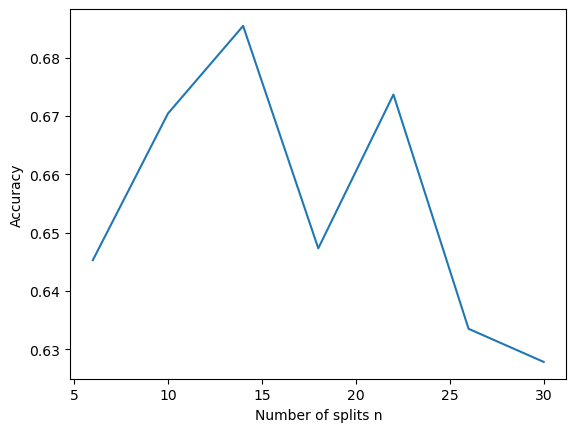

In [99]:

plt.plot(range(6,34,4),accuracy_scores)
plt.xlabel("Number of splits n")
plt.ylabel("Accuracy")
plt.show()

The best result is obtained with n = 10. 

Then we add the categorical features encoded and we proced with the resampling of the data. Random forest and SVM benefits of this process. 

In [121]:
X_spectograms = get_spectograms(X_signal_removed_silence,n=10)

#For each recors, contains the spectogram and the categorical features
X_all_features = []

for i in range(X_spectograms.shape[0]):
    X_all_features.append( np.hstack((X_spectograms[i],df_corr.iloc[i,1:])) )

X_all_features = np.array(X_all_features)


In [122]:
from sklearn.utils import resample


N = 2614  #number of records belonging to the class most common
X_resampled = X_all_features
y_samples = labels

for label,count in labels_count.items():
    
    X_class = np.array([x for i,x in enumerate(X_all_features) if labels[i] == label])
    n = X_class.shape[0]
    samples = resample(X_class,n_samples=N-n)
    X_resampled = np.vstack((X_resampled,samples))
    y_samples = y_samples + list([label]*(N-n))
    
Counter(y_samples)

Counter({'change languagenone': 2614,
         'activatemusic': 2614,
         'deactivatelights': 2614,
         'increasevolume': 2614,
         'decreasevolume': 2614,
         'increaseheat': 2614,
         'decreaseheat': 2614})

In [123]:
X_resampled.shape

(18298, 205)

### Hyperparameters tuning 

We run a grid search both on Random forest and SVM.

In [125]:
X_train_rs,X_test_rs,y_train_rs,y_test_rs = train_test_split(X_resampled,y_samples,test_size=0.2,stratify=X_resampled[:,201])

In [126]:
#GRID SEARCH ON RANDOM FOREST
from sklearn.model_selection import ParameterGrid

params = {
    "max_depth" : [None, 10, 50,100],
    "n_estimators" : [100,200],
    "criterion" : ["gini", "entropy"]
}

accuracies = []
for config in ParameterGrid(params):
    clf = RandomForestClassifier(**config)
    clf.fit(X_train_rs,y_train_rs)
    y_pred = clf.predict(X_test_rs)
    accuracy = accuracy_score(y_test_rs,y_pred)
    accuracies.append(accuracy)
    print(f"configuration: {config} accuracy: {accuracy}\n")

print("Accuracy:", max(accuracies))
best_config = list(ParameterGrid(params))[np.argmax(accuracies)]
print("Best configuration:",best_config)

configuration: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 100} accuracy: 0.907103825136612

configuration: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 200} accuracy: 0.9144808743169399

configuration: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100} accuracy: 0.8543715846994535

configuration: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200} accuracy: 0.8620218579234973

configuration: {'criterion': 'gini', 'max_depth': 50, 'n_estimators': 100} accuracy: 0.9103825136612022

configuration: {'criterion': 'gini', 'max_depth': 50, 'n_estimators': 200} accuracy: 0.9153005464480874

configuration: {'criterion': 'gini', 'max_depth': 100, 'n_estimators': 100} accuracy: 0.9128415300546449

configuration: {'criterion': 'gini', 'max_depth': 100, 'n_estimators': 200} accuracy: 0.9166666666666666

configuration: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100} accuracy: 0.9073770491803279

configuration: {'criterion': 'entropy', 'max_

The SVM model benefits of the normalization of the data. We apply a Z-score normalization to the features.

In [127]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
X_ft_scaled = scaler.fit_transform(X_resampled)

In [128]:
X_train_scaled, X_test_scaled, y_train_scaled,y_test_scaled = train_test_split(X_ft_scaled,y_samples,test_size = 0.2,stratify=X_resampled[:,201]) 

In [129]:
# GRID SEARCH ON SVM

params = {
    "C" : [1, 5, 10,20,50,100],
    "kernel" : ['rbf']
}

accuracies = []
for config in ParameterGrid(params):
    clf = SVC(**config)
    clf.fit(X_train_scaled,y_train_scaled)
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test_scaled,y_pred)
    accuracies.append(accuracy)
    print(f"configuration: {config} accuracy: {accuracy}\n")

print("Accuracy:", max(accuracies))
best_config = list(ParameterGrid(params))[np.argmax(accuracies)]
print("Best configuration:", best_config)

configuration: {'C': 1, 'kernel': 'rbf'} accuracy: 0.8666666666666667

configuration: {'C': 5, 'kernel': 'rbf'} accuracy: 0.9210382513661202

configuration: {'C': 10, 'kernel': 'rbf'} accuracy: 0.9316939890710383

configuration: {'C': 20, 'kernel': 'rbf'} accuracy: 0.9330601092896175

configuration: {'C': 50, 'kernel': 'rbf'} accuracy: 0.9322404371584699

configuration: {'C': 100, 'kernel': 'rbf'} accuracy: 0.9319672131147541

Accuracy: 0.9330601092896175
Best configuration: {'C': 20, 'kernel': 'rbf'}


The best results have been obtained with:
- Random forest : criterion = gini,  max_depth = none,  n_estimators = 200
- SVM: C = 10,  kernel = rbf

### Classification on evaluation set

Let's import the evaluation set. We pass through the previous steps and apply our model to classify records in the evaluation set. 

In [130]:
df_eval = pd.read_csv('./dsl_data/evaluation.csv')
df_eval.head(10)

,Id,path,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,0,dsl_data/audio/speakers/NgQEvO2x7Vh3xy2xz/f53c...,NgQEvO2x7Vh3xy2xz,native,English (United States),English (United States),male,22-40
1,1,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/1d5f8...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40
2,2,dsl_data/audio/speakers/7B4XmNppyrCK977p/1c0d5...,7B4XmNppyrCK977p,native,English (United States),English (United States),male,41-65
3,3,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/275c3...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40
4,4,dsl_data/audio/speakers/V4ZbwLm9G5irobWn/b7c7a...,V4ZbwLm9G5irobWn,native,English (United States),English (United States),female,41-65
5,5,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/8d017...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40
6,6,dsl_data/audio/speakers/V4ejqNL4xbUKkYrV/f8769...,V4ejqNL4xbUKkYrV,native,English (United States),English (United States),male,22-40
7,7,dsl_data/audio/speakers/NgQEvO2x7Vh3xy2xz/628b...,NgQEvO2x7Vh3xy2xz,native,English (United States),English (United States),male,22-40
8,8,dsl_data/audio/speakers/4BrX8aDqK2cLZRYl/ec446...,4BrX8aDqK2cLZRYl,native,English (United States),English (United States),female,22-40
9,9,dsl_data/audio/speakers/aokxBz9LxXHzZzay/3d40c...,aokxBz9LxXHzZzay,native,English (United States),English (United States),female,22-40


In [131]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455 entries, 0 to 1454
Data columns (total 8 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Id                                     1455 non-null   int64 
 1   path                                   1455 non-null   object
 2   speakerId                              1455 non-null   object
 3   Self-reported fluency level            1455 non-null   object
 4   First Language spoken                  1455 non-null   object
 5   Current language used for work/school  1455 non-null   object
 6   gender                                 1455 non-null   object
 7   ageRange                               1455 non-null   object
dtypes: int64(1), object(7)
memory usage: 91.1+ KB


In [132]:
df_eval_encoded = df_eval

df_eval_encoded['Self-reported fluency level '].replace(
        ['native','advanced','basic','intermediate'],
        [0,1,2,3],inplace=True)


df_eval_encoded['First Language spoken'].replace(
        ['English (United States)','French (Canada)','Spanish (Venezuela)','Telugu','English (Canada)'],
        [0,1,2,3,4],inplace=True)

df_eval_encoded['Current language used for work/school'].replace(
        ['English (United States)','English (Canada)','English (Australia)','Spanish (Venezuela)'],
        [0,1,2,3],inplace=True)

df_eval_encoded['gender'].replace(
        ['male','female'], [0,1],inplace=True)

df_eval_encoded['ageRange'].replace(
        ['22-40','41-65','65+'], [0,1,2],inplace=True)

df_eval_encoded.head()

,Id,path,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,0,dsl_data/audio/speakers/NgQEvO2x7Vh3xy2xz/f53c...,NgQEvO2x7Vh3xy2xz,0,0,0,0,0
1,1,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/1d5f8...,k5bqyxx2lzIbrlg9,0,0,0,0,0
2,2,dsl_data/audio/speakers/7B4XmNppyrCK977p/1c0d5...,7B4XmNppyrCK977p,0,0,0,0,1
3,3,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/275c3...,k5bqyxx2lzIbrlg9,0,0,0,0,0
4,4,dsl_data/audio/speakers/V4ZbwLm9G5irobWn/b7c7a...,V4ZbwLm9G5irobWn,0,0,0,1,1


We extract the signals from the evaluation set

In [133]:
#EXTRACT AUDIO FROM EVALUATION SET
X_eval_signal = []

for i in range(len(df_eval)):
    path = './'+df_eval.loc[i,'path']
    signal, sample_rate = librosa.load(path,sr=sample_rate)
    X_eval_signal.append(signal) 

In [134]:
X_eval_removed_silence = [remove_silence(x) for x in X_eval_signal]

We extract the mel spectrogram and we divide them into nxn blocks, with n = 14. As we have seen, it leads to the best result.

In [138]:
X_eval_spectograms = get_spectograms(X_eval_removed_silence,n=10)

X_eval_spec_with_categorical = []

for i in range(len(X_eval_spectograms)):
    X_eval_spec_with_categorical.append( np.hstack((X_eval_spectograms[i],df_eval_encoded.iloc[i,3:] ) ) )


In [139]:
X_eval_all_features = np.array(X_eval_spec_with_categorical)

Let's classify the recordings of the evaluation set using a SVM and a Random forest classifiers with the best configurations obtained

In [140]:
rfc = RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=200)
rfc.fit(X_resampled,y_samples)
y_pred = rfc.predict(X_eval_all_features)

In [141]:
import csv

with open('submission_final_RFC.csv', 'w', newline='') as file:
     writer = csv.writer(file)
    
     writer.writerow(['Id','Predicted'])
     
     for i in range(len(y_pred)):
            writer.writerow([i,y_pred[i]])

In [142]:
scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
X_eval_scaled = scaler.fit_transform(X_eval_all_features)

In [143]:
svc = SVC(C=20,kernel='rbf')
svc.fit(X_ft_scaled,y_samples)
y_pred_svc = svc.predict(X_eval_scaled)

In [144]:
with open('submission_final_SVC.csv', 'w', newline='') as file:
     writer = csv.writer(file)
    
     writer.writerow(['Id','Predicted'])
     
     for i in range(len(y_pred)):
            writer.writerow([i,y_pred_svc[i]])